In [12]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim

import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Value, Case, When, IntegerField

---
### importing data

In [106]:
run_id = 1749
dts = DocTopic.objects.filter(run_id=run_id)
# total score of all DocTopics
print(dts.aggregate(
    n = Sum('score')
))
# total score of DocTopics, sorted by topic
pd.DataFrame.from_dict(list(dts.values('topic__id', 'topic__title').annotate(
    totalscore = Sum('score')
).order_by('-totalscore')))

{'n': 1217271.60000067}


,topic__id,topic__title,totalscore
0,167076,economy & jobs,180209.304923
1,167091,finance,112460.880056
2,167080,mixed 3,94209.943619
3,167068,targets,64741.055996
4,167089,climate policy,63732.679546
5,167087,budget,63582.044014
6,167086,procedural 1,55375.995602
7,167072,electricity market,53139.689184
8,167071,procedural 3,48017.864272
9,167088,mixed 2,39828.917121


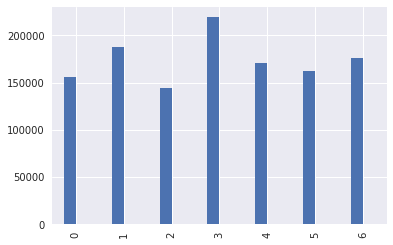

In [166]:
dts_list = list(dts.values('ut__document__parlperiod__n').annotate(
    n = Sum('score')
))
df_dts_list = pd.DataFrame(dts_list)
df_dts_list.columns = ['DocTopic_score', 'parlperiod']
df_dts_list.set_index('parlperiod')
df_dts_list.plot(kind='bar', legend=False)

In [142]:
stat = RunStats.objects.get(run_id=run_id)
search = stat.psearch
uts = pm.Utterance.objects.filter(search_matches=search)
print(uts.count())

period_counts = uts.values('document__parlperiod__n').annotate(n=Count('document__parlperiod__n'))
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))

3502


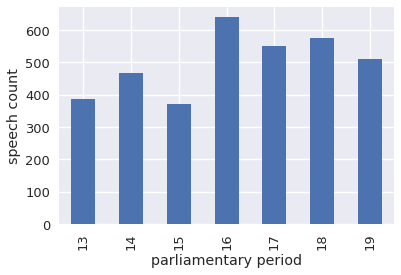

In [200]:
# plot parliamentary period counts
sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index('document__parlperiod__n')
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig('./plots/topic_analysis/parlperiod_speech_count_search_{}.png'.format(search.id), dpi=300,  bbox_inches="tight")

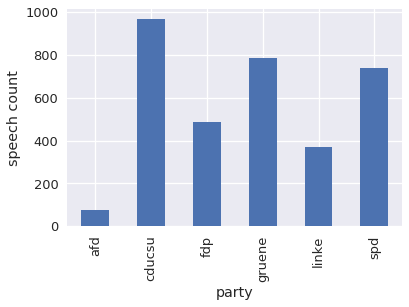

In [201]:
# plot party counts
df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

# drop some of the labels:
df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])

df_party_counts.plot(kind='bar', legend=False)
plt.xlabel('party')
plt.ylabel('speech count')
fig = plt.gcf()
fig.savefig('./plots/topic_analysis/party_speech_count_search_{}.png'.format(search.id), dpi=300,  bbox_inches="tight")

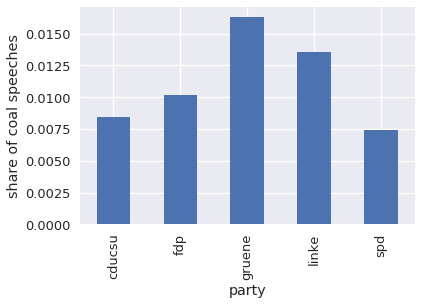

In [203]:
# party shares
party_counts = uts.values('speaker__party__name').annotate(n=Count('speaker__party__name'))
party_counts_all = pm.Utterance.objects.all().values('speaker__party__name').annotate(n_tot=Count('speaker__party__name'))


df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index('speaker__party__name')

df_party_counts_all = pd.DataFrame.from_dict(party_counts_all)
df_party_counts_all = df_party_counts_all.set_index('speaker__party__name')

df_pc = df_party_counts.join(df_party_counts_all)

df_pc['share'] = df_pc['n'] / df_pc['n_tot']

# drop some of the labels:
df_pc = df_pc.drop(["fraktionslos", "parteilos", "pds", "afd", None])

df_pc.plot(kind='bar', y="share", legend=False)
plt.xlabel('party')
plt.ylabel('share of coal speeches')
fig = plt.gcf()
fig.savefig('./plots/topic_analysis/party_share_search_{}.png'.format(search.id), dpi=300,  bbox_inches="tight")

In [187]:
df_party_counts

,n
speaker__party__name,
afd,75
cducsu,967
fdp,486
fraktionslos,1
gruene,786
linke,370
parteilos,6
pds,26
spd,738


---

### Overall DocTopic score - Time plot

**test topics**: steinkohl, umweltschutz, international, forschung, saar 

In [7]:
dts.values('topic__title','ut__document__parlperiod__n').annotate(n = Sum('score'))

<QuerySet [{'topic__title': 'biofuels', 'ut__document__parlperiod__n': 13, 'n': 61.8117244112657}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 14, 'n': 424.51964030433}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 15, 'n': 432.947342206544}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 16, 'n': 1417.24567542906}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 17, 'n': 514.802727196122}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 18, 'n': 118.530374559672}, {'topic__title': 'biofuels', 'ut__document__parlperiod__n': 19, 'n': 45.05627222465}, {'topic__title': 'budget', 'ut__document__parlperiod__n': 13, 'n': 4020.43055332205}, {'topic__title': 'budget', 'ut__document__parlperiod__n': 14, 'n': 8191.58099268052}, {'topic__title': 'budget', 'ut__document__parlperiod__n': 15, 'n': 10795.561074388}, {'topic__title': 'budget', 'ut__document__parlperiod__n': 16, 'n': 14252.1724163039}, {'topic__title': 'budget', 'ut__d

In [205]:
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_scores

topic,EU,R&D,biofuels,budget,budget 2,climate policy,climate protection,conservation,development,east germany,...,mixed 2,mixed 3,nuclear,power grid,procedural 1,procedural 2,procedural 3,rail transport,regional policy,targets
parlperiod,,,,,,,,,,,,,,,,,,,,,
13,5955.863199,530.782580,61.811724,4020.430553,10095.628009,1111.896145,318.081842,3701.979917,1968.118784,4923.591435,...,2472.045842,21773.459996,9057.436350,149.164999,3999.396379,11470.990826,2487.200603,1181.790995,269.182973,3230.808594
14,3773.262851,1419.063368,424.519640,8191.580993,6682.683676,3817.963250,377.805710,5979.605565,4215.261612,5560.430663,...,3536.037914,19772.601862,14684.265830,333.287345,4748.419454,3527.363217,3053.575610,686.936595,335.985066,8302.992925
15,3661.284880,3097.230114,432.947342,10795.561074,5354.827462,3942.108815,251.947130,4099.762046,1554.865033,2013.966965,...,1766.579420,17482.062852,2497.681113,152.883987,4239.353143,998.743889,3305.734944,178.047042,632.592731,6877.115212
16,7648.922903,1531.167578,1417.245675,14252.172416,6252.624283,26351.087210,1602.705327,5551.642496,5869.579806,1046.577316,...,4808.854188,12908.815429,4090.401112,1672.100282,8733.312489,6544.146129,6971.611508,533.451362,773.242405,21071.629075
17,4664.452797,562.036966,514.802727,9667.501885,2384.575334,11642.525494,1384.131745,4696.981825,5048.243393,3271.535924,...,5593.404469,11185.216046,6521.903371,3701.193892,5321.765634,3183.664910,9290.685498,1219.499798,697.225141,10787.922673
18,4878.319780,803.409228,118.530375,8322.378400,1239.292299,13891.910152,13827.602912,3396.463071,6238.357906,3900.249543,...,7719.176128,6668.217127,1379.597828,1850.986297,11231.317111,6031.396666,13016.050543,617.705327,1746.760246,8005.124360
19,3796.750267,322.559906,45.056272,8332.418691,386.234365,2975.188480,19186.067248,2349.884059,1723.434565,3796.303686,...,13932.819160,4419.570308,1394.628443,840.221651,17102.431392,775.965635,9893.005565,1200.430659,7627.892212,6465.463158


In [208]:
# normalization
df_shares = df_scores.copy()
for i in df_shares.index:
    df_shares.loc[i] = df_scores.loc[i] / df_scores.loc[i].sum() * 100
df_shares

topic,EU,R&D,biofuels,budget,budget 2,climate policy,climate protection,conservation,development,east germany,...,mixed 2,mixed 3,nuclear,power grid,procedural 1,procedural 2,procedural 3,rail transport,regional policy,targets
parlperiod,,,,,,,,,,,,,,,,,,,,,
13,3.806471,0.339230,0.039505,2.569510,6.452249,0.710628,0.203290,2.365984,1.257851,3.146732,...,1.579917,13.915706,5.788727,0.095333,2.556067,7.331262,1.589603,0.755298,0.172038,2.064852
14,2.005819,0.754356,0.225669,4.354542,3.552431,2.029581,0.200837,3.178683,2.240780,2.955855,...,1.879713,10.510867,7.805972,0.177171,2.524200,1.875102,1.623242,0.365167,0.178605,4.413767
15,2.538992,2.147837,0.300236,7.486400,3.713413,2.733735,0.174718,2.843063,1.078253,1.396626,...,1.225070,12.123290,1.732067,0.106020,2.939865,0.692599,2.292429,0.123470,0.438684,4.769075
16,3.489770,0.698585,0.646609,6.502458,2.852718,12.022507,0.731224,2.532900,2.677956,0.477494,...,2.194008,5.889561,1.866218,0.762885,3.984515,2.985723,3.180751,0.243384,0.352787,9.613790
17,2.727474,0.328643,0.301024,5.652938,1.394347,6.807806,0.809352,2.746495,2.951890,1.912985,...,3.270666,6.540400,3.813593,2.164222,3.111829,1.861604,5.432600,0.713086,0.407693,6.308089
18,3.007506,0.495305,0.073075,5.130784,0.764029,8.564426,8.524780,2.093935,3.845976,2.404522,...,4.758907,4.110986,0.850528,1.141142,6.924158,3.718384,8.024455,0.380818,1.076886,4.935196
19,2.156224,0.183186,0.025588,4.732089,0.219348,1.689648,10.896018,1.334530,0.978761,2.155970,...,7.912630,2.509932,0.792028,0.477173,9.712694,0.440681,5.618367,0.681740,4.331979,3.671821


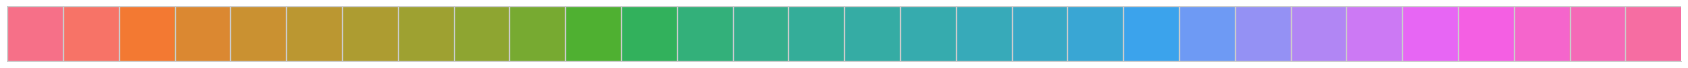

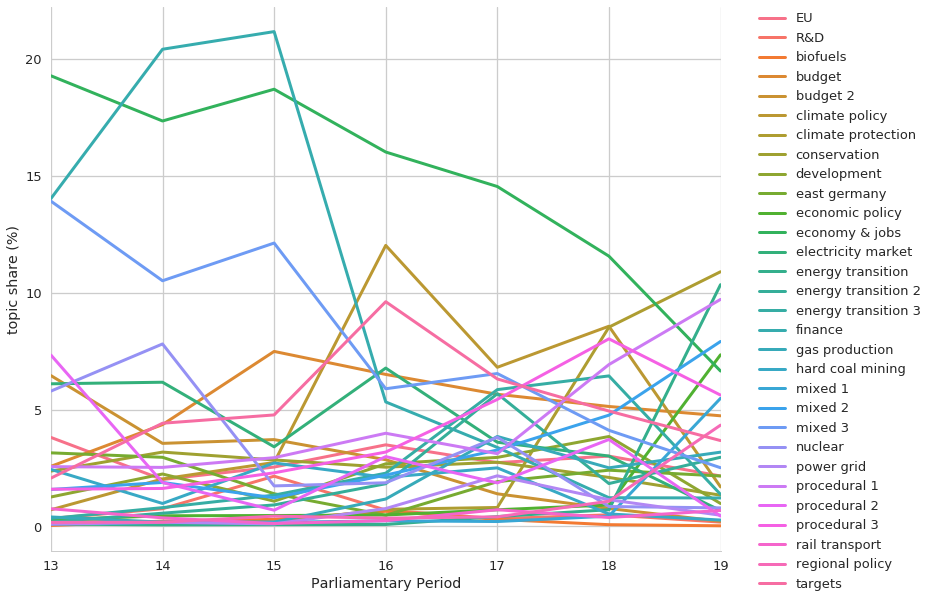

In [248]:
%matplotlib inline
# figure aesthetics
sns.set_style('whitegrid')
plt.rcParams['lines.linewidth'] = 3

sns.set_palette('husl', 30)
#sns.set_palette('muted')
sns.palplot(sns.color_palette())

ax = df_shares.plot(figsize=(12,10), xticks = df_shares.index)
ax.set(xlabel='Parliamentary Period', ylabel='topic share (%)')

fig = plt.gcf()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# fig.savefig('dtopicscore_topic_comparison.png')

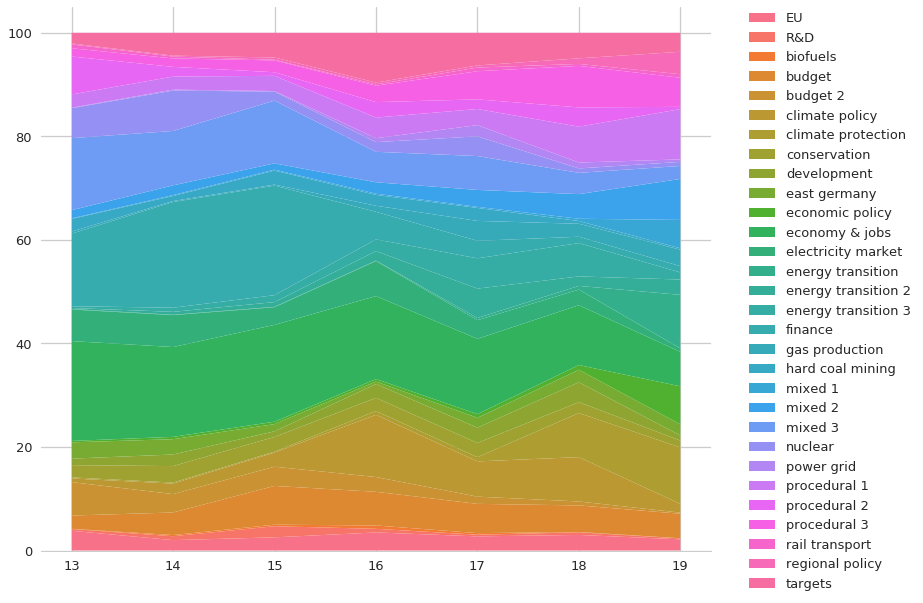

In [249]:
fig = plt.figure(figsize=(12,10))
plt.stackplot(df_shares.index, df_shares.T, labels=df_shares.columns)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

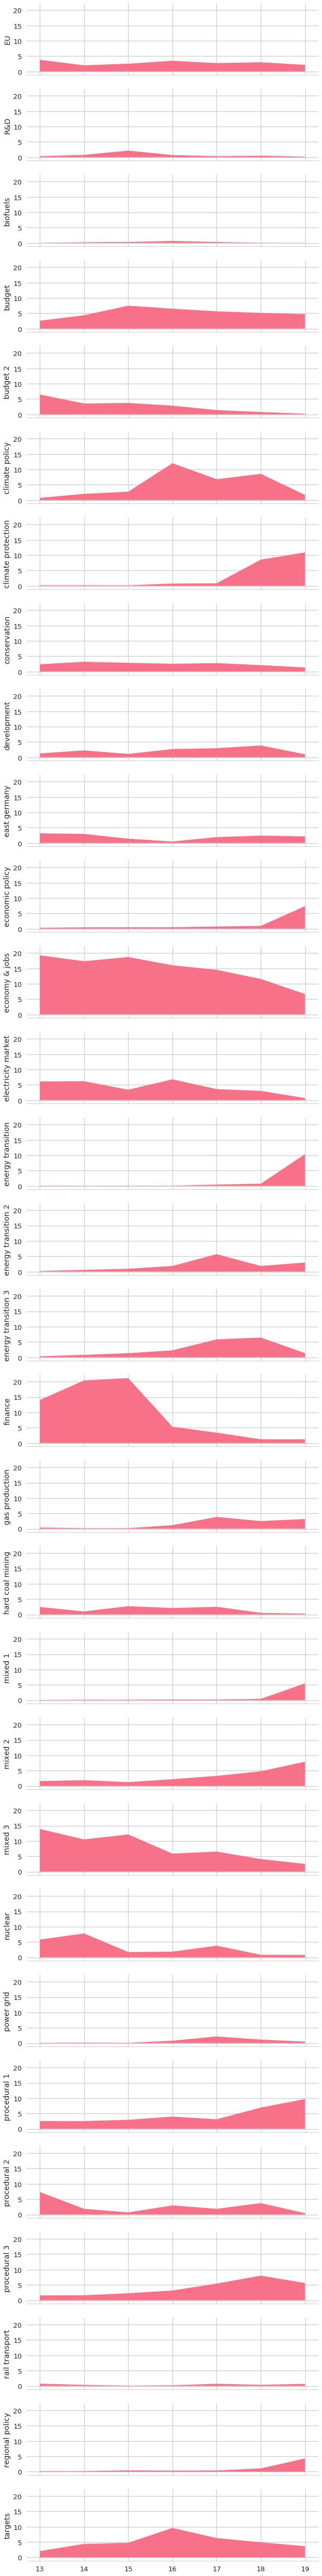

In [215]:
#dfs = df[["EU", "finance"]]
dfs = df_shares
#print(dfs)

fig, ax = plt.subplots(len(dfs.columns), 1, figsize=(10, len(dfs.columns)*3), sharex=True, sharey=True)

for i, t in enumerate(dfs.columns):
    ax[i].stackplot(dfs.index, dfs[t])
    ax[i].set_ylabel(t)

#fig.save('')

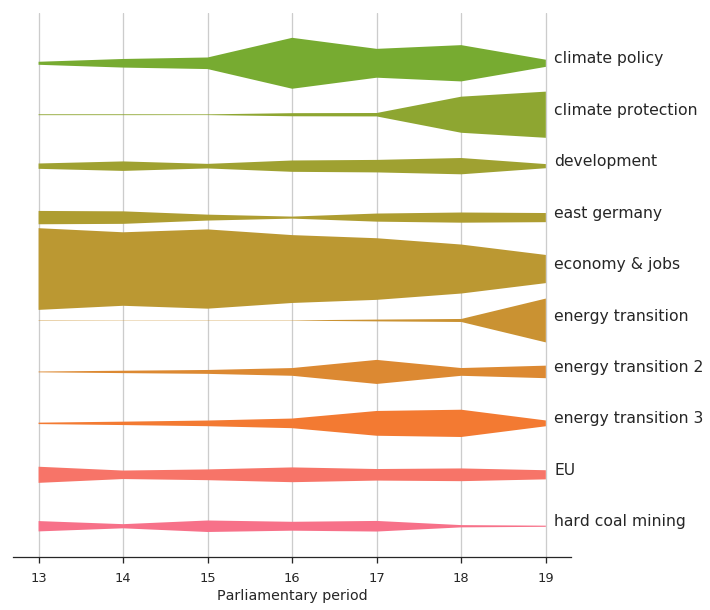

In [218]:
#dfs = df[["EU", "finance"]]
dfs = df_shares[["hard coal mining",  "EU", "energy transition 3", "energy transition 2", "energy transition",
          "economy & jobs", "east germany", "development", "climate protection", "climate policy"]]
#print(dfs)

sns.set_context("talk")
sns.set_style("ticks")
sns.set_style({'axes.spines.bottom': True,
               'axes.grid':True,
 'axes.spines.left': False,
 'axes.spines.right': False,
 'axes.spines.top': False,
 'ytick.left': False})


fig = plt.figure(figsize=(10, len(dfs.columns)))
max_val = dfs.max().max() + 5

for i, t in enumerate(dfs.columns):
    plt.fill_between(dfs.index, dfs[t] + i*max_val, i*max_val - dfs[t], label=t)
    plt.text(19.1, (i+0.) *max_val, t)

ax = fig.gca()
plt.yticks([])

plt.xlabel('Parliamentary period')
plt.savefig('./plots/topic_analysis/topic_selection_run1749.png', dpi=300, bbox_inches="tight")


---

### Party Analysis

#### one topic

In [240]:
# from parliament/views.py
topic_id = 167089 # climate policy
topic_id = 167076 # economy and jobs
topic_label = Topic.objects.get(id=topic_id).title
t1_party_totals = pm.Utterance.objects.filter(
    doctopic__topic__run_id=run_id, 
    speaker__party__name__isnull=False,
    speaker__party__colour__isnull=False
).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
    topic_score=Sum(
        Case(
            When(doctopic__topic=topic_id,
                 then=F('doctopic__score')),
            default=0,
            output_field=models.FloatField()
        )),
    total_score=Sum('doctopic__score'),
).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
    'document__parlperiod__n', #parlperiod
    'topic_score', #doctopicscore
    'total_score',
    'topic_proportion',
    'speaker__party__id',
    'speaker__party__name',
    'speaker__party__colour'
).order_by('-document__parlperiod__n')

In [241]:
dft1 = pd.DataFrame.from_dict(list(t1_party_totals))
dft1.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft1_n = pd.DataFrame([dft1['parlperiod'], dft1['party_name'], dft1['doctopic_score']]).transpose()
dft1_n = dft1_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

In [242]:
# manual setting of colour, needs to be adjusted with new party or order change 
party_colour = ["#0088FF", "#000000", "#FFED00", "#64A12D", "#8C3473", "#EB001F"]
sns.set_palette(party_colour)
sns.set_context('talk')

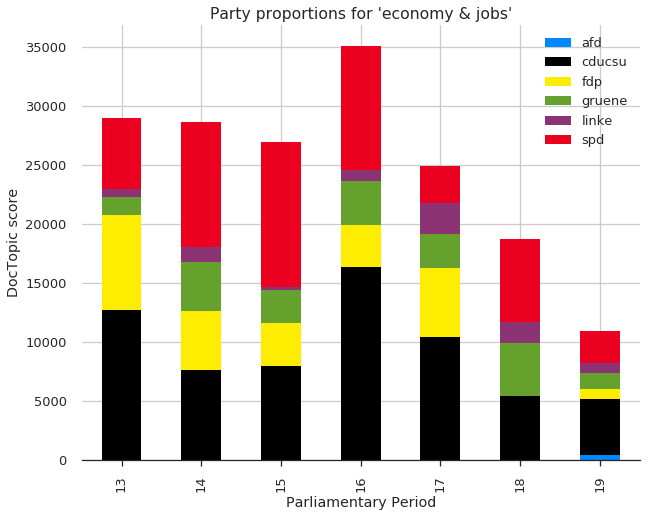

In [243]:
# Stacked bar plot
ax = dft1_n.plot(kind='bar', stacked=True, # title=topic_names[0],
                 figsize=(10,8), xticks = dft1_n.index)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score', title="Party proportions for '{}'".format(topic_label))
plt.legend(title="")

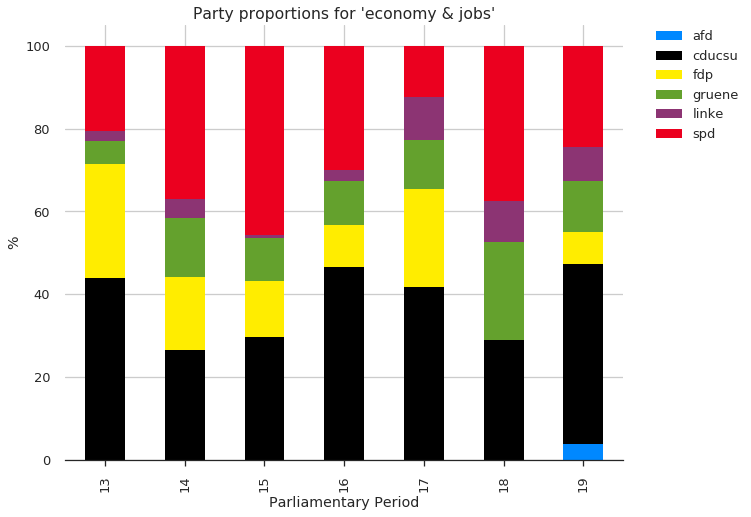

In [244]:
# Stacked bar plot proportions
dft_shares = dft1_n.copy()
for i in dft_shares.index:
    dft_shares.loc[i] = dft_shares.loc[i] / dft_shares.loc[i].sum() * 100

ax = dft_shares.plot(kind='bar', stacked=True, # title=topic_names[0],
                 figsize=(10,8), xticks = dft_shares.index)
ax.set(xlabel='Parliamentary Period', ylabel='%', title="Party proportions for '{}'".format(topic_label))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig = plt.gcf()
plt.savefig('./plots/topic_analysis/party_proportions_topic_{}.png'.format(topic_id), dpi=300, bbox_inches="tight")

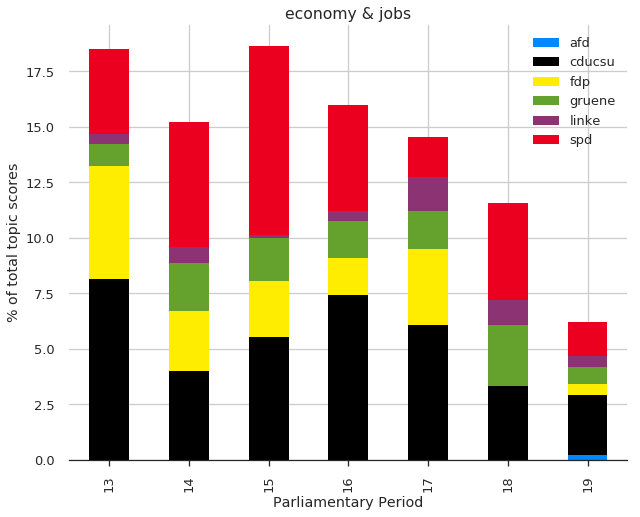

In [245]:
# Stacked bar plot proportions
dft_shares = dft1_n.copy()
for i in dft_shares.index:
    dft_shares.loc[i] = dft_shares.loc[i] / df_scores.loc[i].sum() * 100

ax = dft_shares.plot(kind='bar', stacked=True, # title=topic_names[0],
                 figsize=(10,8), xticks = dft_shares.index)
ax.set(xlabel='Parliamentary Period', ylabel='% of total topic scores', title="{}".format(topic_label))
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(title="")

fig = plt.gcf()
plt.savefig('./plots/topic_analysis/party_shares_topic_{}.png'.format(topic_id), dpi=300, bbox_inches="tight")

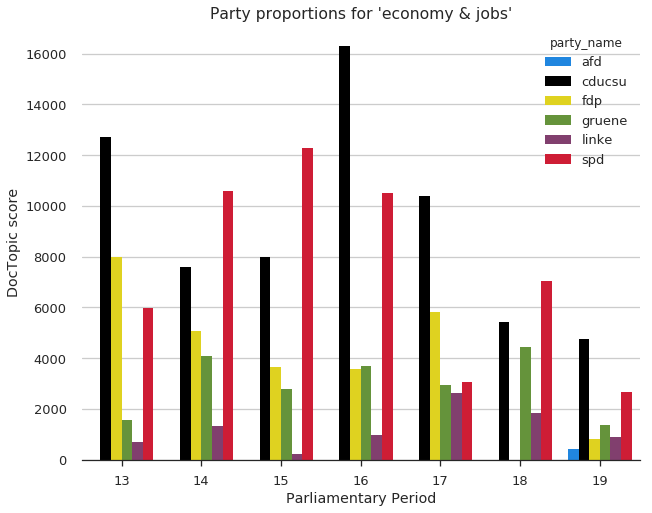

In [246]:
# adding custom colour palette - automatic assignment 
# plot using seaborn barplot 
# problem: can't stack, but can manually edit for stack
dft1_test = pd.DataFrame([dft1['parlperiod'], dft1['party_name'], dft1['doctopic_score']]).transpose()
de_party = dict(cducsu="#000000", gruene="#64A12D", linke="#8C3473", spd="#EB001F", fdp="#FFED00", afd="#0088FF")

fig, ax = plt.subplots(figsize=[10,8])
sns.barplot(data=dft1_test, x ='parlperiod', y='doctopic_score', hue='party_name', palette=de_party)
ax.set(xlabel='Parliamentary Period', ylabel='DocTopic score', title="Party proportions for '{}'".format(topic_label))
plt.show()

#### multiple topics

In [236]:
topic_ids = [167083, 167075, 167079, 167076, 167089]
#topic_ids = [167078, 167074, 167072, 167087, 167091]
party_totals = []
topic_names = []
for i in topic_ids:
    topic_party_totals = pm.Utterance.objects.filter(
        doctopic__topic__run_id=run_id, 
        speaker__party__name__isnull=False,
        speaker__party__colour__isnull=False
    ).order_by().values('speaker__party__name','document__parlperiod__n').annotate(
        topic_score=Sum(
            Case(
                When(doctopic__topic=i,
                     then=F('doctopic__score')),
                default=0,
                output_field=models.FloatField()
            )),
        total_score=Sum('doctopic__score'),
    ).annotate(topic_proportion=F('topic_score') / F('total_score')).values(
        'document__parlperiod__n', #parlperiod
        'topic_score', #doctopicscore
        'total_score',
        'topic_proportion',
        'speaker__party__id', 
        'speaker__party__name',
        'speaker__party__colour'
    ).order_by('-document__parlperiod__n')
    
    party_totals.append(list(topic_party_totals))
    
    t_name = Topic.objects.get(id=i).title
    topic_names.append(t_name)


In [237]:
# create data frame from party_totals
dft2 = pd.DataFrame.from_dict(list(party_totals[1]))
dft2.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft2_n = pd.DataFrame([dft2['parlperiod'], dft2['party_name'], dft2['doctopic_score']]).transpose()
dft2_n = dft2_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft3 = pd.DataFrame.from_dict(list(party_totals[2]))
dft3.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft3_n = pd.DataFrame([dft3['parlperiod'], dft3['party_name'], dft3['doctopic_score']]).transpose()
dft3_n = dft3_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft4 = pd.DataFrame.from_dict(list(party_totals[3]))
dft4.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft4_n = pd.DataFrame([dft4['parlperiod'], dft4['party_name'], dft4['doctopic_score']]).transpose()
dft4_n = dft4_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

dft5 = pd.DataFrame.from_dict(list(party_totals[4]))
dft5.columns = ['parlperiod', 'party_colour', 'party_id', 'party_name', 'doctopic_proportion', 'doctopic_score', 'total_doctopic_score']
dft5_n = pd.DataFrame([dft5['parlperiod'], dft5['party_name'], dft5['doctopic_score']]).transpose()
dft5_n = dft5_n.pivot(index='parlperiod', columns='party_name', values='doctopic_score')

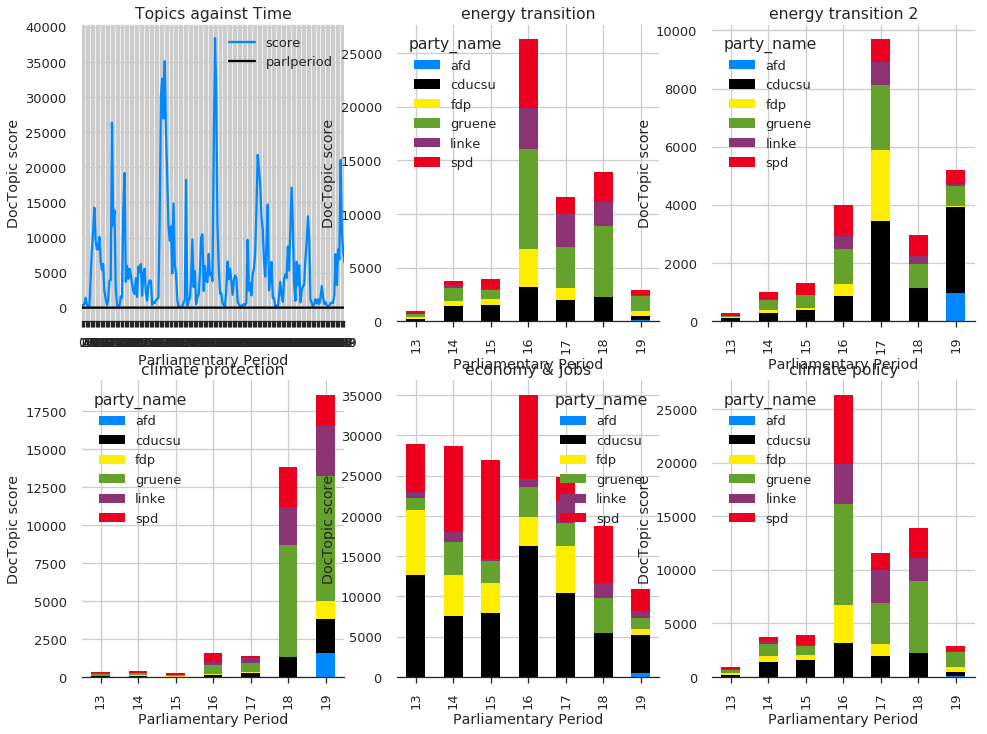

In [238]:
# create multiple plots of topic-time-party plot side by side, stacked bars
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=3)

df.plot(title='Topics against Time', xticks = df.index, ax=ax[0,0])
ax[0,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 1
dft1_n.plot(kind='bar', stacked=True, title=topic_names[0], xticks = dft1_n.index, ax=ax[0,1])
ax[0,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 2
dft2_n.plot(kind='bar', stacked=True, title=topic_names[1], xticks = dft1_n.index, ax=ax[0,2])
ax[0,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 3
dft3_n.plot(kind='bar', stacked=True, title=topic_names[2], xticks = dft1_n.index, ax=ax[1,0])
ax[1,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score')                 

# topic 4
dft4_n.plot(kind='bar', stacked=True, title=topic_names[3], xticks = dft1_n.index, ax=ax[1,1])
ax[1,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

# topic 5
dft5_n.plot(kind='bar', stacked=True, title=topic_names[4], xticks = dft1_n.index, ax=ax[1,2])
ax[1,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score')

plt.show()

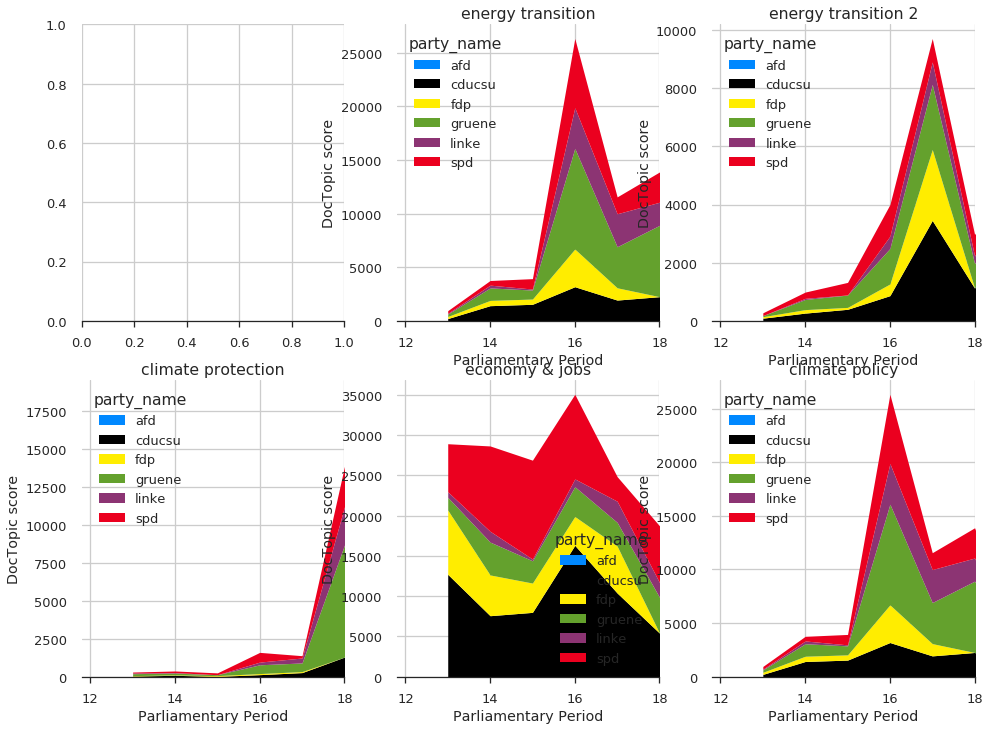

In [239]:
# create multiple plots of topic-time-party plot side by side, stacked area 
fig, ax = plt.subplots(figsize=[16,12], nrows=2, ncols=3)

dft1_n.plot(kind='area', linewidth=0, ax=ax[0,1])
ax[0,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[0], xlim=(11.8,18))

dft2_n.plot(kind='area', linewidth=0, ax=ax[0,2])
ax[0,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[1], xlim=(11.8,18))

dft3_n.plot(kind='area', linewidth=0, ax=ax[1,0])
ax[1,0].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[2], xlim=(11.8,18))

dft4_n.plot(kind='area', linewidth=0, ax=ax[1,1])
ax[1,1].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[3], xlim=(11.8,18))

dft5_n.plot(kind='area', linewidth=0, ax=ax[1,2])
ax[1,2].set(xlabel='Parliamentary Period', ylabel='DocTopic score', title=topic_names[4], xlim=(11.8,18))

plt.show()

---